In [1]:
import pysd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections as cl
import math

In [2]:
vensimDirectory='./Simulation Files/Prosumers & defectors'
vensimFile ='net metering-no fixed tariff.mdl'
filepath = Path(vensimDirectory,vensimFile)
model = pysd.read_vensim(str(filepath))

In [17]:
model.doc()

,Real Name,Py Name,Unit,Lims,Type,Eqn,Comment
0,"""No. Batteries""",no_batteries,b'Dmnl',"(None, None)",component,b'INTEGER(Average Daily Battery Eenergy)+1',b''
1,"""No. Bettery Replacement""",no_bettery_replacement,b'Dmnl',"(None, None)",component,"b'IF THEN ELSE(MODULO(PV Life, Battery Life )=...",b''
2,"""No. PVs""",no_pvs,b'Dmnl',"(None, None)",component,b'INTEGER(Regular Consumer Average Demand*(1+R...,b''
3,Actual Prosumer Demand Change,actual_prosumer_demand_change,b'',"(None, None)",component,b'INTEG ( change in indicated prosumer demand-...,b''
4,Actual Regular Customer Demand change,actual_regular_customer_demand_change,b'kWh/(Month*Customer)',"(None, None)",component,b'INTEG ( change in indicated regular consumer...,b''
...,...,...,...,...,...,...,...
98,installing battery imitation factor,installing_battery_imitation_factor,b'1/(Customer*Month)',"(None, None)",component,b'final yearly percent/(12*1e+06*5)',b''
99,installing battery imitation percent,installing_battery_imitation_percent,b'1/Month',"(None, None)",component,b'Defectors*installing battery imitation facto...,b''
100,installing battery innovation factor,installing_battery_innovation_factor,b'1/Month',"(None, None)",constant,b'0.01/12',b''
101,price elasticity of prosumers,price_elasticity_of_prosumers,b'Dmnl',"(None, None)",constant,b'-0.2',b''


In [3]:
paramaters={
    'population growth rate':0.001,
    'time to adjust Prosumer Demand':1,
    'time to adjust Regular Consumer demand':1,
    'Tariff Correction Period':1   
}

In [4]:
price={}
step_range=[2**-p for p in range(4)]
for s in step_range:
    price[s] = model.run(params={**paramaters,'TIME STEP': s},return_columns=['Electricity Tariff'])

Simulation Files\Prosumers & defectors\net metering-no fixed tariff.py:681: RuntimeWarning: invalid value encountered in double_scalars
  prosumer_average_demand() / electricity_tariff())
Simulation Files\Prosumers & defectors\net metering-no fixed tariff.py:699: RuntimeWarning: invalid value encountered in double_scalars
  price_elasticity_of_regular_consumers() / electricity_tariff())
Simulation Files\Prosumers & defectors\net metering-no fixed tariff.py:681: RuntimeWarning: divide by zero encountered in double_scalars
  prosumer_average_demand() / electricity_tariff())
Simulation Files\Prosumers & defectors\net metering-no fixed tariff.py:699: RuntimeWarning: divide by zero encountered in double_scalars
  price_elasticity_of_regular_consumers() / electricity_tariff())


In [5]:
[(p,price[p].loc[:,'Electricity Tariff'].max()) for p in price]

[(1, 0.9656872168569972),
 (0.5, 0.5682693952698741),
 (0.25, 0.3488966831961741),
 (0.125, 0.20440740279697256)]

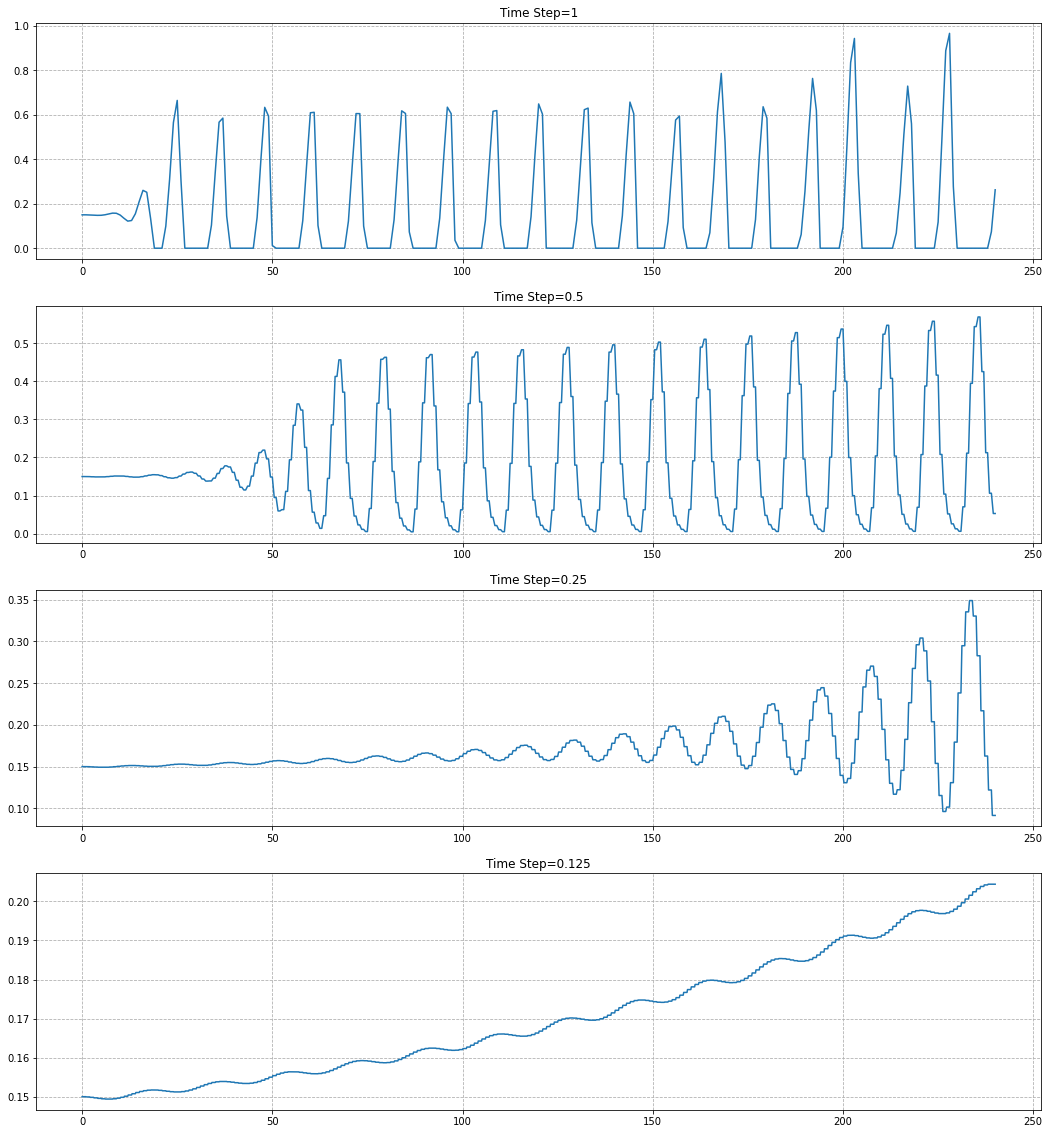

In [6]:
fig,ax = plt.subplots(len(step_range),1)
fig.set_size_inches(18,len(step_range)*5)
for i,s in enumerate(step_range):
    ax[i].plot(price[s].loc[:,'Electricity Tariff'])
    ax[i].grid(True,linestyle='--')
    ax[i].title.set_text(f'Time Step={s}')


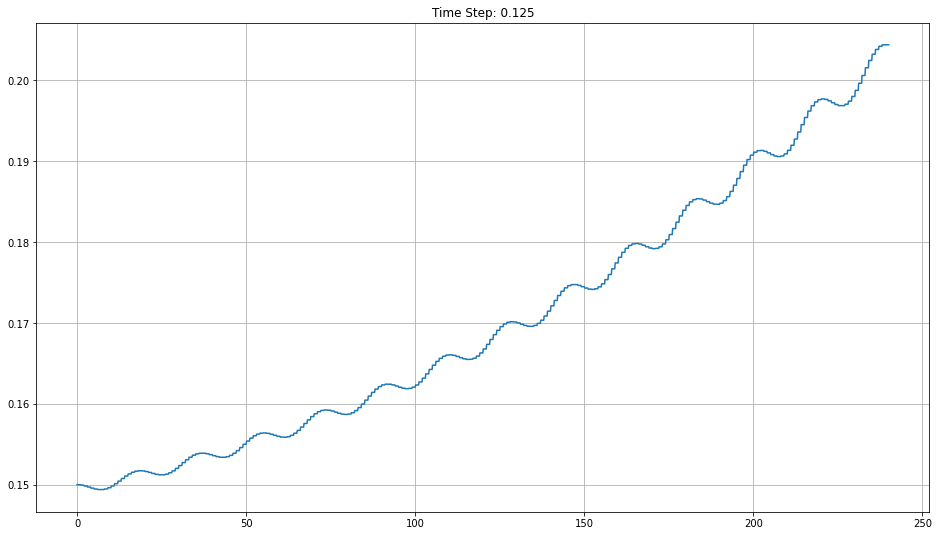

In [7]:
index=3
plt.figure(figsize=(16,9))
plt.grid()
plt.plot(price[step_range[index]].loc[:,'Electricity Tariff'])
plt.title(f'Time Step: {step_range[index]}');

In [8]:
def myshape(x,a,b,c,tc,f,phi):
    return a*(np.exp(tc*x)-1)+b*np.sin(2*np.pi*f*x+phi)+c

In [9]:
from scipy.optimize import curve_fit
import numpy as np

In [10]:
time =np.arange(0,240+2**-index,2**-index)
y=price[step_range[index]].loc[:,'Electricity Tariff'].to_numpy()
popt,pcov=curve_fit(f=myshape,xdata=time,ydata=y)

C:\Users\Sara\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [11]:
print(pcov)
print(popt)

[[inf inf inf inf inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]]
[-6.39957312e-14  1.70827082e+85 -4.34202907e+71  1.00000000e+00
  6.21234538e+83 -2.32220476e+86]


In [12]:
def myfunc(x,a,b,c,tc,f,phi):
    return a*(np.exp(tc*x)-1)+b*np.sin(2*np.pi*f*x+phi)+c

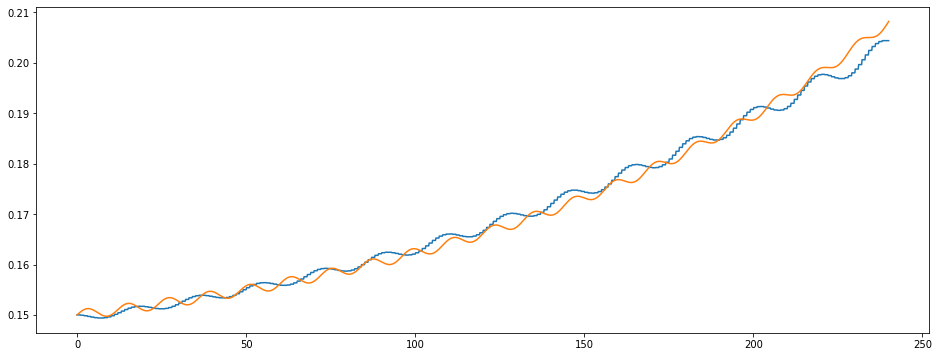

In [13]:
stimated=myshape(time,a=0.1,b=0.01,c=0.15,tc=0.05,f=0.1,phi=np.pi)
plt.figure(figsize=(16,6))
plt.plot(time,y)
plt.plot(time,myfunc(time,a=0.01,tc=0.008,c=0.15,f=1/12,phi=0,b=0.001))
# plt.yscale('log')

In [14]:
dif=[]
for i,p in enumerate(y):
    if (i-1)%8==0:
        dif.append(y[i]-y[i-1])

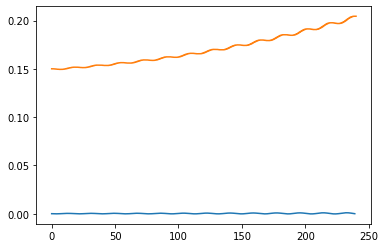

In [15]:
plt.plot(dif)
plt.plot(time,y)